In [1]:
import pandas as pd
import sys
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from sklearn import metrics
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

//anaconda/envs/PREDICT/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv('train_auto.csv')
test = pd.read_csv('test_auto.csv')

In [3]:
test.columns

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [4]:
train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [5]:
train.columns = [s.lower() for s in train.columns]
test.columns = [s.lower() for s in test.columns]

### Summary of Data

In [6]:
train_columns = train.columns
print(train_columns)

Index(['index', 'target_flag', 'target_amt', 'kidsdriv', 'age', 'homekids',
       'yoj', 'income', 'parent1', 'home_val', 'mstatus', 'sex', 'education',
       'job', 'travtime', 'car_use', 'bluebook', 'tif', 'car_type', 'red_car',
       'oldclaim', 'clm_freq', 'revoked', 'mvr_pts', 'car_age', 'urbanicity'],
      dtype='object')


In [7]:
train.shape

(8161, 26)

In [8]:
test.shape

(2141, 26)

In [9]:
test_columns = test.columns
print(test_columns)

Index(['index', 'target_flag', 'target_amt', 'kidsdriv', 'age', 'homekids',
       'yoj', 'income', 'parent1', 'home_val', 'mstatus', 'sex', 'education',
       'job', 'travtime', 'car_use', 'bluebook', 'tif', 'car_type', 'red_car',
       'oldclaim', 'clm_freq', 'revoked', 'mvr_pts', 'car_age', 'urbanicity'],
      dtype='object')


In [10]:
# show descriptive statistics
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,8161.0,5151.867663,2978.893962,1.0,2559.0,5133.0,7745.0,10302.00000
target_flag,8161.0,0.263816,0.440728,0.0,0.0,0.0,1.0,1.00000
target_amt,8161.0,1504.324648,4704.026930,0.0,0.0,0.0,1036.0,107586.13616
kidsdriv,8161.0,0.171057,0.511534,0.0,0.0,0.0,0.0,4.00000
age,8155.0,44.790313,8.627589,16.0,39.0,45.0,51.0,81.00000
homekids,8161.0,0.721235,1.116323,0.0,0.0,0.0,1.0,5.00000
yoj,7707.0,10.499286,4.092474,0.0,9.0,11.0,13.0,23.00000
travtime,8161.0,33.485725,15.908333,5.0,22.0,33.0,44.0,142.00000
tif,8161.0,5.351305,4.146635,1.0,1.0,4.0,7.0,25.00000
clm_freq,8161.0,0.798554,1.158453,0.0,0.0,0.0,2.0,5.00000


# Data Exploration

In [11]:
def find_outliers(dataSeries):
    quants = dataSeries.quantile([.25, .75])
    iqr = quants[.75] - quants[.25]
    
    lower = quants[.25] - 3 * iqr
    upper = quants[.75] + 3 * iqr
    return [value for value in dataSeries if value < lower or value > upper]

In [12]:
eda_train = train.copy()
print(eda_train.describe().transpose())

              count         mean          std   min     25%     50%     75%  \
index        8161.0  5151.867663  2978.893962   1.0  2559.0  5133.0  7745.0   
target_flag  8161.0     0.263816     0.440728   0.0     0.0     0.0     1.0   
target_amt   8161.0  1504.324648  4704.026930   0.0     0.0     0.0  1036.0   
kidsdriv     8161.0     0.171057     0.511534   0.0     0.0     0.0     0.0   
age          8155.0    44.790313     8.627589  16.0    39.0    45.0    51.0   
homekids     8161.0     0.721235     1.116323   0.0     0.0     0.0     1.0   
yoj          7707.0    10.499286     4.092474   0.0     9.0    11.0    13.0   
travtime     8161.0    33.485725    15.908333   5.0    22.0    33.0    44.0   
tif          8161.0     5.351305     4.146635   1.0     1.0     4.0     7.0   
clm_freq     8161.0     0.798554     1.158453   0.0     0.0     0.0     2.0   
mvr_pts      8161.0     1.695503     2.147112   0.0     0.0     1.0     3.0   
car_age      7651.0     8.328323     5.700742  -3.0 

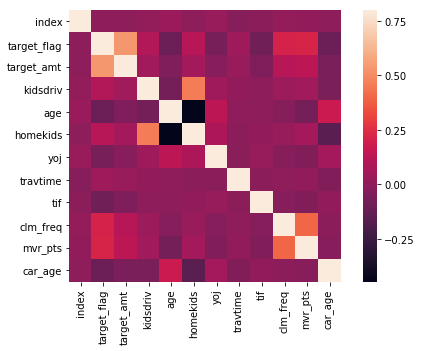

In [13]:
#correlation matrix
corr_matrix = eda_train.corr()
f, ax = plt.subplots(figsize = (8, 5))
sns.heatmap(corr_matrix, vmax = .8, square = True)

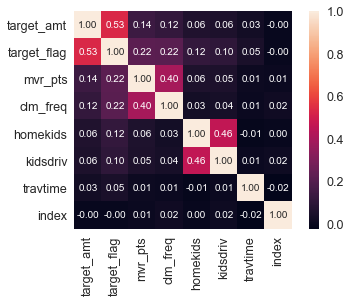

In [14]:
eda_train["target_amt"] = eda_train["target_amt"].fillna(0)
columns = corr_matrix.nlargest(8, 'target_amt')['target_amt'].index
corr_m = np.corrcoef(eda_train[columns].values.T)
sns.set(font_scale = 1.25)
heat_map = sns.heatmap(corr_m, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = columns.values, xticklabels = columns.values)
plt.show()

## Continuous

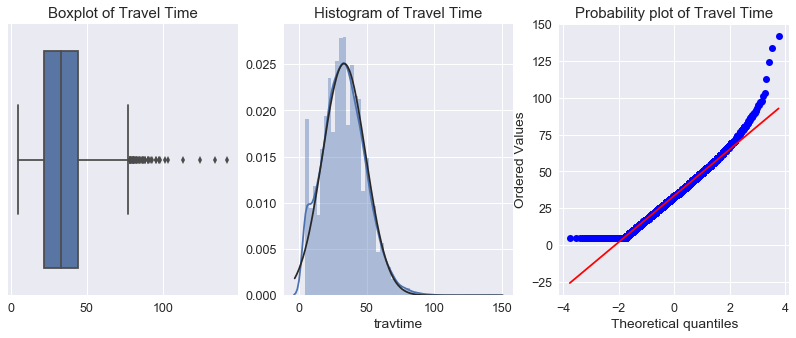

Outliers for Travel Time:  [113, 124, 142, 134]


In [15]:
# let's look at the travel time first
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 3, 1)
axs1 = sns.boxplot([eda_train.travtime])
axs1.set_title('Boxplot of Travel Time')

ax2 = plt.subplot(1, 3, 2)
axs2 = sns.distplot(eda_train.travtime, fit=norm, hist=True)
axs2.set_title("Histogram of Travel Time")

ax3 = plt.subplot(1, 3, 3)
axs3 = stats.probplot(eda_train.travtime, plot=plt)
ax3.set_title("Probability plot of Travel Time")

plt.show()

print("Outliers for Travel Time: ", find_outliers(eda_train.travtime))

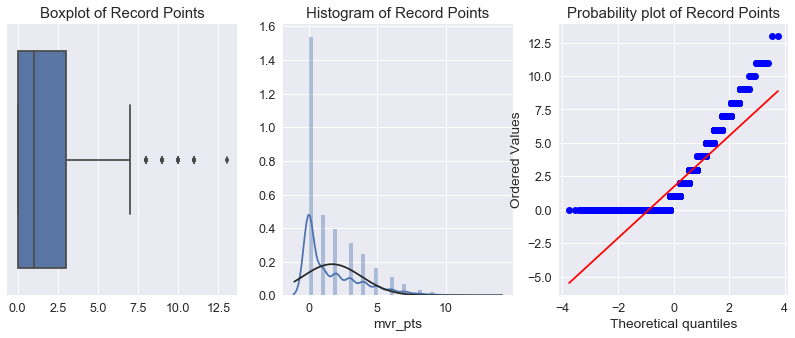

Outliers for Motor Vehicle Record Points:  [13, 13]


In [16]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 3, 1)
axs1 = sns.boxplot([eda_train.mvr_pts])
axs1.set_title('Boxplot of Record Points')

ax2 = plt.subplot(1, 3, 2)
axs2 = sns.distplot(eda_train.mvr_pts, fit=norm, hist=True)
axs2.set_title("Histogram of Record Points")

ax3 = plt.subplot(1, 3, 3)
axs3 = stats.probplot(eda_train.mvr_pts, plot=plt)
ax3.set_title("Probability plot of Record Points")

plt.show()

print("Outliers for Motor Vehicle Record Points: ", find_outliers(eda_train.mvr_pts))

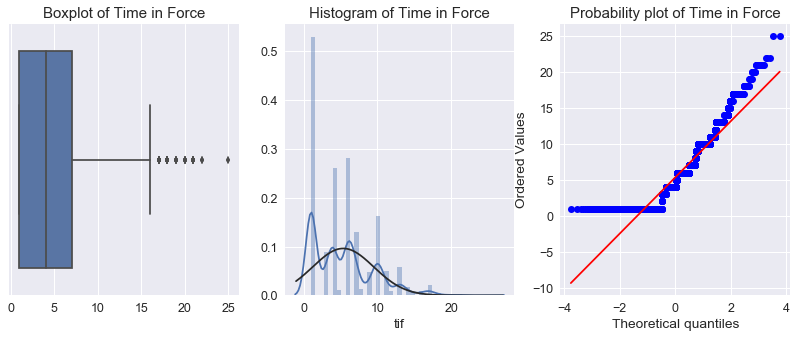

Outliers for Time In Force:  []


In [17]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 3, 1)
axs1 = sns.boxplot([eda_train.tif])
axs1.set_title('Boxplot of Time in Force')

ax2 = plt.subplot(1, 3, 2)
axs2 = sns.distplot(eda_train.tif, fit=norm, hist=True)
axs2.set_title("Histogram of Time in Force")

ax3 = plt.subplot(1, 3, 3)
axs3 = stats.probplot(eda_train.tif, plot=plt)
ax3.set_title("Probability plot of Time in Force")

plt.show()

print("Outliers for Time In Force: ",find_outliers(eda_train.tif))

In [18]:
# Remove extra characters from the dataset
from decimal import Decimal
from re import sub
for index in list(train.columns.values):
    if train[index].astype(str).str.contains("\$").any() == True:
        tempVals = []
        for money in train[index].values:
            if not pd.isnull(money):
                value = int(Decimal(sub(r'[^\d\-.]', '', money)))
                tempVals.append(value)
            else:
                tempVals.append(np.nan)
        eda_train[index] = tempVals
   
eda_train.income = eda_train.income.fillna(0)
m = np.median(eda_train.income)
print(m)
eda_train.income = eda_train.income.replace({0: m}).astype(int)        

51116.0


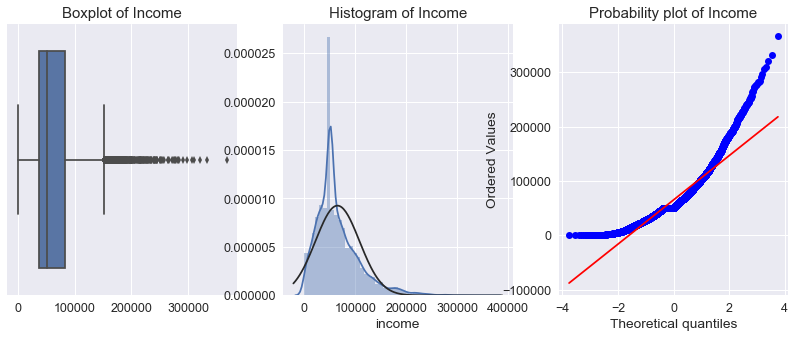

[266027, 282292, 245498, 255823, 227092, 227493, 332339, 221413, 222372, 225083, 220533, 220722, 297435, 276054, 252222, 225311, 275392, 264481, 367030, 235075, 256870, 249589, 219768, 226422, 226674, 234568, 235986, 250286, 253058, 243751, 320127, 244905, 264817, 232256, 238874, 284071, 228376, 242362, 223259, 271813, 273507, 229724, 241408, 290846, 231004, 238724, 220881, 234825, 234282, 276354, 240198, 239084, 244076, 240198, 226780, 223020, 241408, 306277, 220895, 309628, 229365, 278656, 252146, 224408, 232280, 242749, 221995, 229983, 282198]


In [19]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 3, 1)
axs1 = sns.boxplot([eda_train.income])
axs1.set_title('Boxplot of Income')

ax2 = plt.subplot(1, 3, 2)
axs2 = sns.distplot(eda_train.income, fit=norm, hist=True)
axs2.set_title("Histogram of Income")

ax3 = plt.subplot(1, 3, 3)
axs3 = stats.probplot(eda_train.income, plot=plt)
ax3.set_title("Probability plot of Income")

plt.show()

print(find_outliers(eda_train.income))

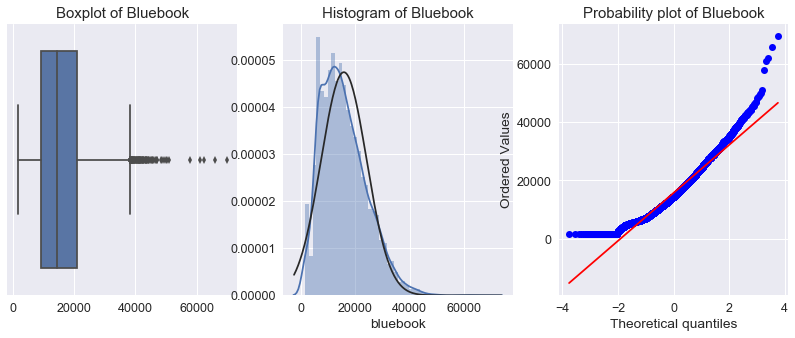

Outliers for Bluebook:  [65970, 62240, 57970, 61050, 69740]


In [20]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 3, 1)
axs1 = sns.boxplot([eda_train.bluebook])
axs1.set_title('Boxplot of Bluebook')

ax2 = plt.subplot(1, 3, 2)
axs2 = sns.distplot(eda_train.bluebook, fit=norm, hist=True)
axs2.set_title("Histogram of Bluebook")

ax3 = plt.subplot(1, 3, 3)
axs3 = stats.probplot(eda_train.bluebook, plot=plt)
ax3.set_title("Probability plot of Bluebook")

plt.show()

print("Outliers for Bluebook: ",find_outliers(eda_train.bluebook))

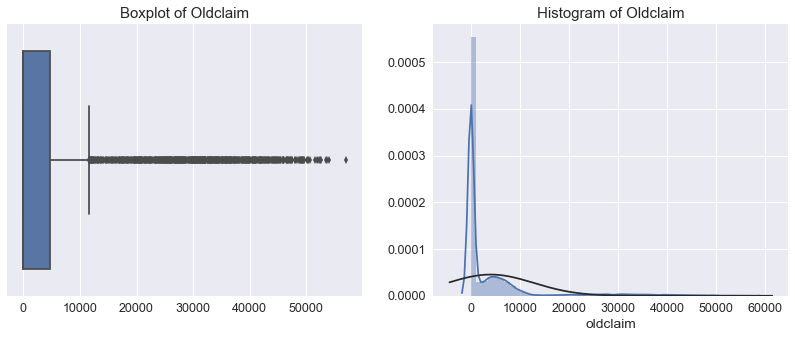

Outliers for Bluebook:  [38690, 19217, 38127, 26104, 27877, 24767, 34351, 25106, 31695, 50701, 19385, 25147, 35666, 35879, 35577, 45574, 20452, 19030, 35430, 41818, 27130, 41913, 36556, 39892, 44414, 41833, 36562, 39535, 30288, 32882, 39614, 34041, 37130, 49641, 44932, 30450, 19545, 23949, 37211, 25664, 39833, 32239, 36267, 31401, 32115, 33218, 37066, 49131, 26871, 43170, 35585, 30001, 41669, 30094, 28274, 45337, 37876, 34941, 46625, 36000, 35165, 23432, 52445, 42820, 23756, 52068, 33030, 30571, 39168, 24930, 30944, 25433, 20060, 25313, 26686, 43052, 37285, 30922, 37129, 31379, 30363, 26023, 19899, 29471, 35737, 29865, 32562, 27872, 28386, 37667, 20778, 29205, 38683, 50111, 21014, 31796, 29781, 38892, 27127, 46652, 44429, 18979, 33223, 34151, 31127, 38774, 27959, 27758, 30791, 48188, 28889, 32639, 22345, 25866, 39204, 21581, 24183, 24310, 45254, 34506, 34195, 35098, 43297, 36486, 30343, 30089, 41917, 39315, 27439, 24512, 37404, 25130, 47939, 41303, 33089, 53477, 39973, 25081, 46442, 35

In [21]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
axs1 = sns.boxplot([eda_train.oldclaim])
axs1.set_title('Boxplot of Oldclaim')

ax2 = plt.subplot(1, 2, 2)
axs2 = sns.distplot(eda_train.oldclaim, fit=norm, hist=True)
axs2.set_title("Histogram of Oldclaim")

plt.show()

print("Outliers for Bluebook: ",find_outliers(eda_train.oldclaim))

## Categorical

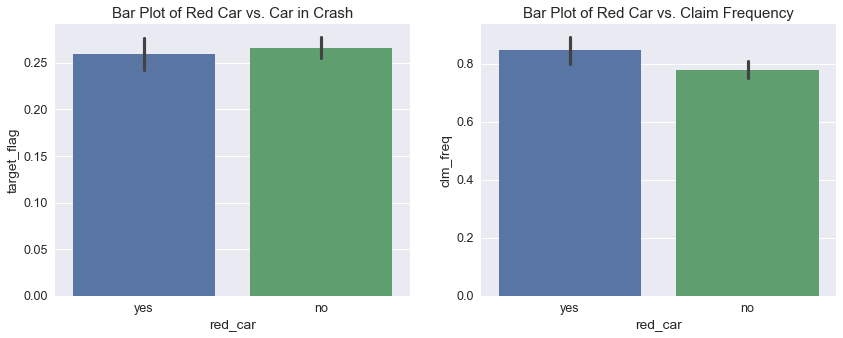

In [22]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
axs1 = sns.barplot(x="red_car", y="target_flag", data=eda_train);
axs1.set_title('Bar Plot of Red Car vs. Car in Crash')
ax2 = plt.subplot(1, 2, 2)
axs2 = sns.barplot(x="red_car", y="clm_freq", data=eda_train);
axs2.set_title('Bar Plot of Red Car vs. Claim Frequency')
plt.show()

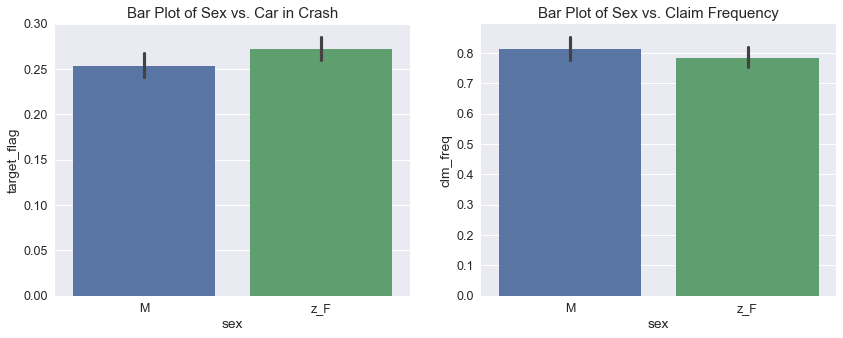

In [23]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
axs1 = sns.barplot(x="sex", y="target_flag", data=eda_train);
axs1.set_title('Bar Plot of Sex vs. Car in Crash')
ax2 = plt.subplot(1, 2, 2)
axs2 = sns.barplot(x="sex", y="clm_freq", data=eda_train);
axs2.set_title('Bar Plot of Sex vs. Claim Frequency')
plt.show()

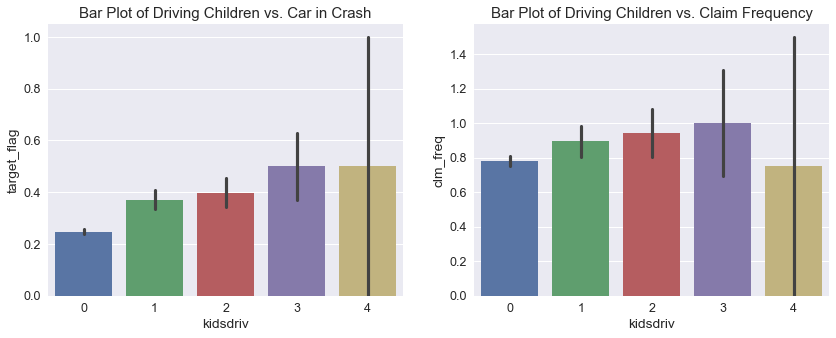

In [24]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
axs1 = sns.barplot(x="kidsdriv", y="target_flag", data=eda_train);
axs1.set_title('Bar Plot of Driving Children vs. Car in Crash')
ax2 = plt.subplot(1, 2, 2)
axs2 = sns.barplot(x="kidsdriv", y="clm_freq", data=eda_train);
axs2.set_title('Bar Plot of Driving Children vs. Claim Frequency')
plt.show()

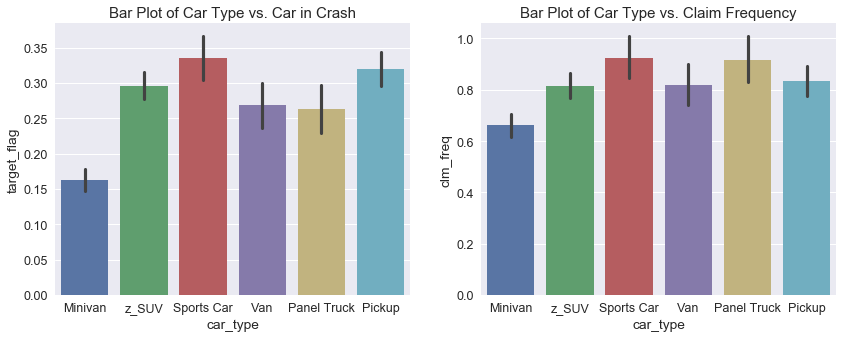

In [25]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
axs1 = sns.barplot(x="car_type", y="target_flag", data=eda_train);
axs1.set_title('Bar Plot of Car Type vs. Car in Crash')
ax2 = plt.subplot(1, 2, 2)
axs2 = sns.barplot(x="car_type", y="clm_freq", data=eda_train);
axs2.set_title('Bar Plot of Car Type vs. Claim Frequency')
plt.show()

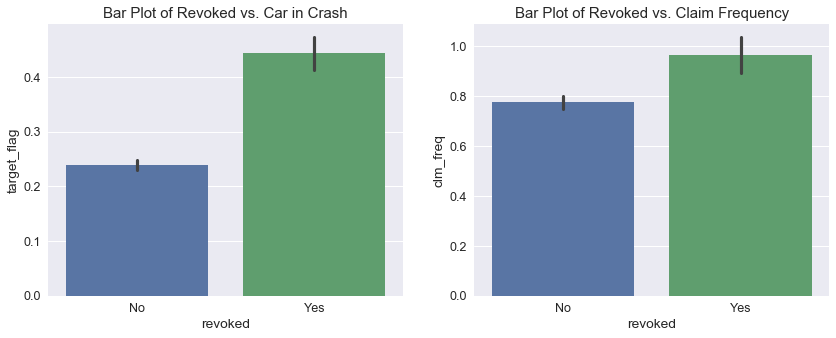

In [26]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
axs1 = sns.barplot(x="revoked", y="target_flag", data=eda_train);
axs1.set_title('Bar Plot of Revoked vs. Car in Crash')
ax2 = plt.subplot(1, 2, 2)
axs2 = sns.barplot(x="revoked", y="clm_freq", data=eda_train);
axs2.set_title('Bar Plot of Revoked vs. Claim Frequency')
plt.show()

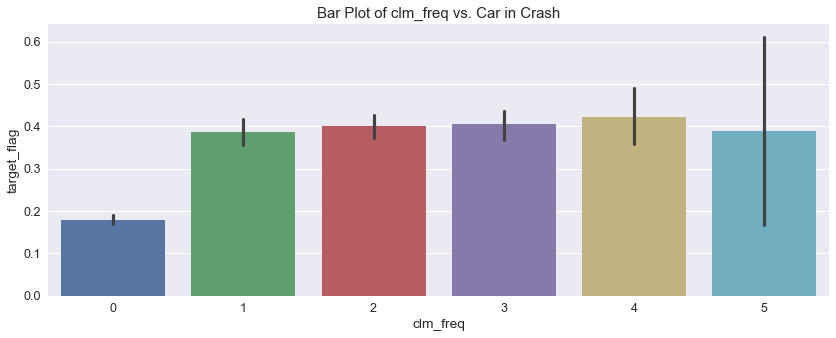

In [27]:
plt.figure(figsize=(14, 5))
axs1 = sns.barplot(x="clm_freq", y="target_flag", data=eda_train);
axs1.set_title('Bar Plot of clm_freq vs. Car in Crash')
plt.show()

# Data Preparation

In [28]:
train1 = train.copy()

In [29]:
naColCount = train1.isnull().sum()
naColCount

index            0
target_flag      0
target_amt       0
kidsdriv         0
age              6
homekids         0
yoj            454
income         445
parent1          0
home_val       464
mstatus          0
sex              0
education        0
job            526
travtime         0
car_use          0
bluebook         0
tif              0
car_type         0
red_car          0
oldclaim         0
clm_freq         0
revoked          0
mvr_pts          0
car_age        510
urbanicity       0
dtype: int64

In [30]:
naColNames = train1.isnull().any()
naColNames

index          False
target_flag    False
target_amt     False
kidsdriv       False
age             True
homekids       False
yoj             True
income          True
parent1        False
home_val        True
mstatus        False
sex            False
education      False
job             True
travtime       False
car_use        False
bluebook       False
tif            False
car_type       False
red_car        False
oldclaim       False
clm_freq       False
revoked        False
mvr_pts        False
car_age         True
urbanicity     False
dtype: bool

In [31]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 26 columns):
index          8161 non-null int64
target_flag    8161 non-null int64
target_amt     8161 non-null float64
kidsdriv       8161 non-null int64
age            8155 non-null float64
homekids       8161 non-null int64
yoj            7707 non-null float64
income         7716 non-null object
parent1        8161 non-null object
home_val       7697 non-null object
mstatus        8161 non-null object
sex            8161 non-null object
education      8161 non-null object
job            7635 non-null object
travtime       8161 non-null int64
car_use        8161 non-null object
bluebook       8161 non-null object
tif            8161 non-null int64
car_type       8161 non-null object
red_car        8161 non-null object
oldclaim       8161 non-null object
clm_freq       8161 non-null int64
revoked        8161 non-null object
mvr_pts        8161 non-null int64
car_age        7651 non-null float

In [32]:
train1.job

0        Professional
1       z_Blue Collar
2            Clerical
3       z_Blue Collar
4              Doctor
5       z_Blue Collar
6       z_Blue Collar
7       z_Blue Collar
8            Clerical
9        Professional
10             Lawyer
11       Professional
12            Manager
13                NaN
14         Home Maker
15           Clerical
16             Lawyer
17             Lawyer
18           Clerical
19      z_Blue Collar
20      z_Blue Collar
21             Lawyer
22      z_Blue Collar
23         Home Maker
24       Professional
25           Clerical
26            Manager
27           Clerical
28         Home Maker
29           Clerical
            ...      
8131    z_Blue Collar
8132              NaN
8133              NaN
8134       Home Maker
8135          Student
8136         Clerical
8137    z_Blue Collar
8138    z_Blue Collar
8139    z_Blue Collar
8140          Student
8141          Manager
8142    z_Blue Collar
8143           Lawyer
8144     Professional
8145      

In [33]:
train1.job = train1.job.fillna("Missing Job Info")
naCols = train1.isnull().any()

In [34]:
# Remove extra characters from the dataset
from decimal import Decimal
from re import sub
for index in list(train.columns.values):
    if train[index].astype(str).str.contains("\$").any() == True:
        tempVals = []
        for money in train[index].values:
            if not pd.isnull(money):
                value = int(Decimal(sub(r'[^\d\-.]', '', money)))
                tempVals.append(value)
            else:
                tempVals.append(np.nan)
        train1[index] = tempVals

In [35]:
train1["home_own"] = np.where(train1["home_val"].fillna(0) > 0, 1, 0)

In [36]:
train1=train1.fillna(0)

In [37]:
for indx in train_columns:
    if naCols[indx] == True:
        newName = "IMP_" + indx
        newInd = "m_" + indx
        m = np.median(train1[indx][train1[indx] > 0])
        train1[newName] = train1[indx].replace({0: m}).astype(int)
        train1[newInd] = (train1[indx] == 0).astype(int)

In [38]:
df = train1.copy()
del(df["index"])
del(df["yoj"])
del(df["income"])
del(df["home_val"])
del(df["age"])
del(df["car_age"])

df["white_collar"] = np.where(df["job"].isin(["Doctor", "Manager", "Lawyer"]), 1, 0)
df["university_degree"] = np.where(df["education"].isin(["Bachelors","Masters", "PhD"]), 1, 0)
df["hadOldClaim"] = np.where(df["oldclaim"] > 0, 1, 0)
df["hadFewOldClaim"] = np.where((df["oldclaim"] > 0) & (df["oldclaim"] <= 12000), 1, 0)
df["hadManyOldClaim"] = np.where(df["oldclaim"] > 12000, 1, 0)

In [39]:
df.columns

Index(['target_flag', 'target_amt', 'kidsdriv', 'homekids', 'parent1',
       'mstatus', 'sex', 'education', 'job', 'travtime', 'car_use', 'bluebook',
       'tif', 'car_type', 'red_car', 'oldclaim', 'clm_freq', 'revoked',
       'mvr_pts', 'urbanicity', 'home_own', 'IMP_age', 'm_age', 'IMP_yoj',
       'm_yoj', 'IMP_income', 'm_income', 'IMP_home_val', 'm_home_val',
       'IMP_car_age', 'm_car_age', 'white_collar', 'university_degree',
       'hadOldClaim', 'hadFewOldClaim', 'hadManyOldClaim'],
      dtype='object')

In [40]:
QRT_1 = 0.99
QRT_2 = 0.01
QRT_3 = 0.95
QRT_4 = 0.05

In [41]:
def replace_outliers_with_q1_q2(series1):
    newSeries = series1.copy()
    series2 = series1.copy()
    for val in range(0, len(series1)):
        if series1[val] > series2.quantile(QRT_1):
            newSeries[val] = series2.quantile(QRT_1)
        
        if series1[val] < series2.quantile(QRT_2):
            newSeries[val] = series2.quantile(QRT_2)
    
    return newSeries

def replace_outliers_with_q3_q4(series1):
    newSeries = series1.copy()
    series2 = series1.copy()
    for val in range(0, len(series1)):
        if series1[val] > series2.quantile(QRT_3):
            newSeries[val] = series2.quantile(QRT_3)
        
        if series1[val] < series2.quantile(QRT_4):
            newSeries[val] = series2.quantile(QRT_4)
    
    return newSeries

In [42]:
df.target_amt = replace_outliers_with_q1_q2(df.target_amt)
df.IMP_income = replace_outliers_with_q1_q2(df.IMP_income)
df.IMP_home_val = replace_outliers_with_q1_q2(df.IMP_home_val)
df.bluebook = replace_outliers_with_q1_q2(df.bluebook)
df.travtime = replace_outliers_with_q1_q2(df.travtime)

In [43]:
#Get dummies
df["IMP_mstatus"] = np.where(df["mstatus"].isin(["Yes"]), 1, 0)
df["IMP_parent1"] = np.where(df["parent1"].isin(["Yes"]), 1, 0)
df["IMP_sex"] = np.where(df["sex"].isin(["z_F"]), 1, 0)
df["IMP_revoked"] = np.where(df["revoked"].isin(["Yes"]), 1, 0)
df["IMP_red_car"] = np.where(df["red_car"].isin(["yes"]), 1, 0)
df["IMP_urbanicity"] = np.where(df["urbanicity"].isin(["Highly Urban/ Urban"]), 1, 0)
df["IMP_car_use"] = np.where(df["car_use"].isin(["Commercial"]), 1, 0)

In [44]:
#continuous vars correlation
continuous_vars = ['target_amt', 'target_flag', 'travtime', 'bluebook', 'tif', 'oldclaim', 
            'clm_freq', 'mvr_pts', 'IMP_age', 'IMP_car_age','IMP_home_val',
            'IMP_income', 'IMP_yoj']
df[continuous_vars].corrwith(df.target_flag)

target_amt      0.724536
target_flag     1.000000
travtime        0.051828
bluebook       -0.105793
tif            -0.082370
oldclaim        0.138084
clm_freq        0.216196
mvr_pts         0.219197
IMP_age        -0.103103
IMP_car_age    -0.097812
IMP_home_val   -0.111835
IMP_income     -0.118405
IMP_yoj        -0.000143
dtype: float64

In [45]:
#categorical vars correlation
dummy_columns = [ 'IMP_red_car', 'IMP_urbanicity', 'IMP_revoked',
                 'IMP_sex','IMP_mstatus','IMP_car_use', 'IMP_parent1',
                 "home_own", "university_degree", "white_collar",
             'kidsdriv', 'homekids', "hadOldClaim", "hadFewOldClaim", "hadManyOldClaim"]
df[dummy_columns].corrwith(df.target_flag)

IMP_red_car         -0.006947
IMP_urbanicity       0.224251
IMP_revoked          0.151939
IMP_sex              0.021079
IMP_mstatus         -0.135125
IMP_car_use          0.142674
IMP_parent1          0.157622
home_own            -0.140721
university_degree   -0.138012
white_collar        -0.144979
kidsdriv             0.103668
homekids             0.115621
hadOldClaim          0.241820
hadFewOldClaim       0.204935
hadManyOldClaim      0.085805
dtype: float64

In [46]:
potential_columns = ["target_flag", "target_amt",
 'bluebook',
 'kidsdriv',
 'homekids',
 'oldclaim',
 'clm_freq',
 'mvr_pts',
 'tif',
 'travtime',
 'IMP_sex',
 'IMP_age',
 'IMP_car_age',
 'IMP_home_val',
 'IMP_income', 'IMP_urbanicity', 'IMP_revoked',
 'IMP_mstatus','IMP_car_use', 'IMP_parent1',
 "home_own", "university_degree", "white_collar", "car_type",
 "hadOldClaim", "hadFewOldClaim", "hadManyOldClaim"]

In [47]:
df_new = df[potential_columns]

In [48]:
corr_matrix = df_new.corr()
print(corr_matrix)


                   target_flag  target_amt  bluebook  kidsdriv  homekids  \
target_flag           1.000000    0.724536 -0.105793  0.103668  0.115621   
target_amt            0.724536    1.000000 -0.038083  0.079273  0.088372   
bluebook             -0.105793   -0.038083  1.000000 -0.021243 -0.107469   
kidsdriv              0.103668    0.079273 -0.021243  1.000000  0.464015   
homekids              0.115621    0.088372 -0.107469  0.464015  1.000000   
oldclaim              0.138084    0.104571 -0.029441  0.020403  0.029911   
clm_freq              0.216196    0.150253 -0.036082  0.037063  0.029349   
mvr_pts               0.219197    0.174579 -0.040260  0.053566  0.060601   
tif                  -0.082370   -0.061401 -0.005188 -0.001989  0.011813   
travtime              0.051828    0.034784 -0.014814  0.006908 -0.008714   
IMP_sex               0.021079    0.001832 -0.063559  0.045934  0.111511   
IMP_age              -0.103103   -0.065103  0.163477 -0.075182 -0.445074   
IMP_car_age 

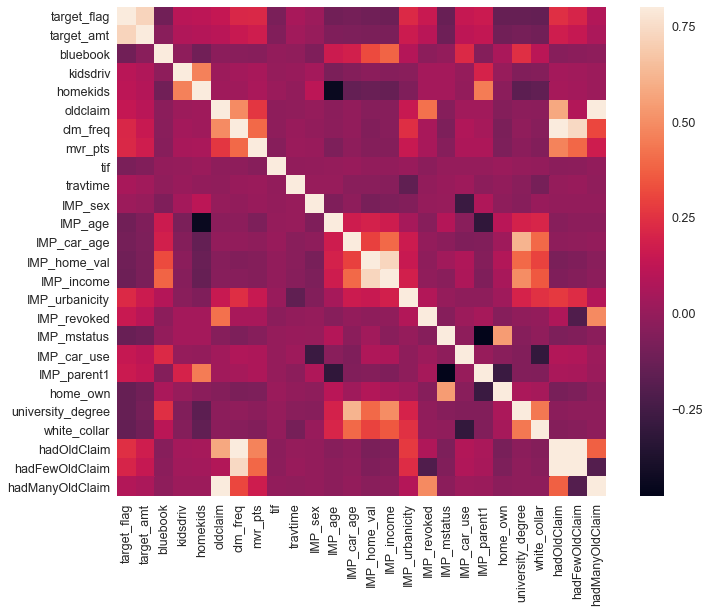

In [49]:
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr_matrix, vmax = .8, square = True)


In [50]:
df_new.columns[2:27]

Index(['bluebook', 'kidsdriv', 'homekids', 'oldclaim', 'clm_freq', 'mvr_pts',
       'tif', 'travtime', 'IMP_sex', 'IMP_age', 'IMP_car_age', 'IMP_home_val',
       'IMP_income', 'IMP_urbanicity', 'IMP_revoked', 'IMP_mstatus',
       'IMP_car_use', 'IMP_parent1', 'home_own', 'university_degree',
       'white_collar', 'car_type', 'hadOldClaim', 'hadFewOldClaim',
       'hadManyOldClaim'],
      dtype='object')

In [51]:
def select_features(inDF, yString, thresh = 3):
    tempList = list(inDF.columns.values)
    tempList.remove(yString)
    inpFeatures = "+".join(tempList)
    y, X = dmatrices(yString + " ~ " + inpFeatures, inDF, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["Features"] = X.columns
    isDone = all(n < thresh for n in vif[vif.Features != "Intercept"]["VIF Factor"])
    if isDone:
        return vif.Features
    else:
        vif_sub = vif[vif.Features != "Intercept"]
        colToTest1 = vif_sub[vif_sub["VIF Factor"] == max(vif_sub["VIF Factor"])]["Features"].values[0]
        vif_sub2 = vif_sub[vif_sub.Features != colToTest1]
        colToTest2 = vif_sub2[vif_sub2["VIF Factor"] == max(vif_sub2["VIF Factor"])]["Features"].values[0]
        
        testDF1 = inDF.drop(colToTest1, 1)
        tempList1 = list(testDF1.columns.values)
        tempList1.remove(yString)
        testFeatures1 = "+".join(tempList1)
        firstModel = smf.logit(yString + " ~ " + testFeatures1, data=testDF1).fit()
        
        testDF2 = inDF.drop(colToTest2, 1)
        tempList2 = list(testDF2.columns.values)
        tempList2.remove(yString)
        testFeatures2 = "+".join(tempList2)
        secondModel = smf.logit(yString + " ~ " + testFeatures2, data=testDF2).fit()
        
        if firstModel.prsquared > secondModel.prsquared:
            return select_features(testDF1, yString)
        elif secondModel.prsquared > firstModel.prsquared:
            return select_features(testDF2, yString)
        else:
            return select_features(testDF1, yString)

In [52]:
import scipy 
print(scipy.__version__)

1.0.0


In [53]:
import statsmodels.formula.api as smf 
import scipy.stats as stats
import scipy.stats

g, p, dof, e = scipy.stats.chi2_contingency([[56, 891], [48, 12873]], correction=True)
print(p) 

1.4896896046343034e-79


In [54]:
features = "+".join(df_new.columns[2:27])
logit1 = smf.logit('target_flag ~ ' + features, data=df_new)
result1 = logit1.fit()
print (result1.conf_int())
print(result1.summary2())

Optimization terminated successfully.
         Current function value: 0.448258
         Iterations 7
                                0             1
Intercept               -3.516483 -2.531773e+00
car_type[T.Panel Truck]  0.189196  7.823812e-01
car_type[T.Pickup]       0.321143  7.044453e-01
car_type[T.Sports Car]   0.749715  1.257538e+00
car_type[T.Van]          0.338140  8.233246e-01
car_type[T.z_SUV]        0.517922  9.540663e-01
bluebook                -0.000035 -1.460143e-05
kidsdriv                 0.265016  5.030811e-01
homekids                -0.030137  1.113529e-01
oldclaim                -0.000019  1.371368e-05
clm_freq                -0.036836  1.361499e-01
mvr_pts                  0.074133  1.289084e-01
tif                     -0.069551 -4.085902e-02
travtime                 0.011455  1.897186e-02
IMP_sex                 -0.245046  1.426809e-01
IMP_age                 -0.009338  6.039600e-03
IMP_car_age             -0.010557  1.692231e-02
IMP_home_val            -0.000003 

//anaconda/envs/PREDICT/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
//anaconda/envs/PREDICT/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/envs/PREDICT/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/envs/PREDICT/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.8127582483302955


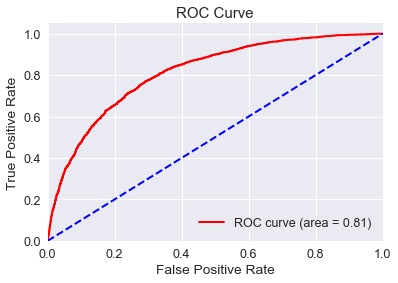

In [55]:
preds = result1.predict()
fpr, tpr, _ = metrics.roc_curve(df_new['target_flag'], preds)

# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [56]:

features2 =  "clm_freq+mvr_pts"
logit2 = smf.logit('target_flag ~ ' + features2, data=df_new)
result2 = logit2.fit()
print(result2.conf_int())
print(result2.summary())
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.544799
         Iterations 5
                  0         1
Intercept -1.658612 -1.511268
clm_freq   0.242288  0.330758
mvr_pts    0.132717  0.180358
                           Logit Regression Results                           
Dep. Variable:            target_flag   No. Observations:                 8161
Model:                          Logit   Df Residuals:                     8158
Method:                           MLE   Df Model:                            2
Date:                Sat, 17 Feb 2018   Pseudo R-squ.:                 0.05582
Time:                        15:01:14   Log-Likelihood:                -4446.1
converged:                       True   LL-Null:                       -4709.0
                                        LLR p-value:                6.853e-115
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

0.6651397764739133


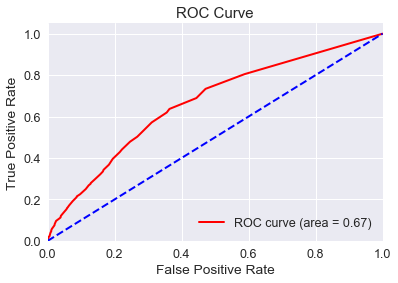

In [57]:
preds = result2.predict()
fpr, tpr, _ = metrics.roc_curve(df_new['target_flag'], preds)

# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [58]:
features3 =  "clm_freq+mvr_pts+IMP_urbanicity"
logit3 = smf.logit('target_flag ~ ' + features3, data=df_new)
result3 = logit3.fit()
print(result3.conf_int())
print(result3.summary())
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.524481
         Iterations 7
                       0         1
Intercept      -3.061252 -2.673234
clm_freq        0.168116  0.258559
mvr_pts         0.122487  0.170697
IMP_urbanicity  1.375261  1.775139
                           Logit Regression Results                           
Dep. Variable:            target_flag   No. Observations:                 8161
Model:                          Logit   Df Residuals:                     8157
Method:                           MLE   Df Model:                            3
Date:                Sat, 17 Feb 2018   Pseudo R-squ.:                 0.09104
Time:                        15:01:14   Log-Likelihood:                -4280.3
converged:                       True   LL-Null:                       -4709.0
                                        LLR p-value:                1.548e-185
                     coef    std err          z      P>|z|      [0.025      0.975]
--------

In [59]:
preds = result3.predict()
fpr, tpr, _ = metrics.roc_curve(df_new['target_flag'], preds)

In [60]:
# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.6994774887547367


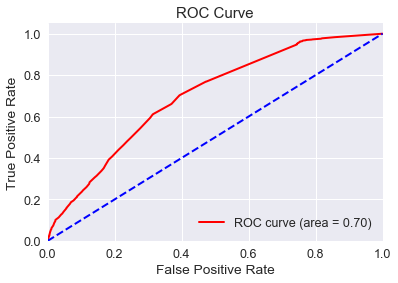

In [61]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [62]:
features4 =  "clm_freq+mvr_pts+IMP_urbanicity+IMP_revoked+IMP_parent1"
logit4 = smf.logit('target_flag ~ ' + features4, data=df_new)
result4 = logit4.fit()
print(result4.conf_int())
print(result4.summary())
print(result4.summary2())

Optimization terminated successfully.
         Current function value: 0.506411
         Iterations 7
                       0         1
Intercept      -3.361636 -2.956270
clm_freq        0.165342  0.257718
mvr_pts         0.114343  0.163679
IMP_urbanicity  1.420031  1.827540
IMP_revoked     0.646964  0.936775
IMP_parent1     0.831996  1.120786
                           Logit Regression Results                           
Dep. Variable:            target_flag   No. Observations:                 8161
Model:                          Logit   Df Residuals:                     8155
Method:                           MLE   Df Model:                            5
Date:                Sat, 17 Feb 2018   Pseudo R-squ.:                  0.1224
Time:                        15:01:15   Log-Likelihood:                -4132.8
converged:                       True   LL-Null:                       -4709.0
                                        LLR p-value:                6.228e-247
                     

In [63]:
preds = result4.predict()
fpr, tpr, _ = metrics.roc_curve(df_new['target_flag'], preds)


In [64]:
# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.7323419370240516


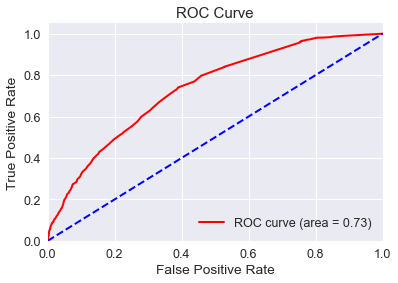

In [65]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [66]:
df_new_2 = df_new.copy()
del(df_new_2["target_amt"])
del(df_new_2["car_type"])

In [67]:
theBestCols = select_features(df_new_2, "target_flag").values
index = np.argwhere(theBestCols=="Intercept")
theBestCols = np.delete(theBestCols, index)
theBestCols = np.append(theBestCols, "target_flag")
df_new_VIF = df_new_2[theBestCols]

//anaconda/envs/PREDICT/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Optimization terminated successfully.
         Current function value: 0.453562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453647
         Iterations 7


In [68]:
tempList = list(df_new_VIF.columns.values)
tempList.remove("target_flag")
testFeatures = "+".join(tempList)
y, X = dmatrices('target_flag ~' + testFeatures, df_new_VIF, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns

print(vif)


    VIF Factor           Features
0    63.003617          Intercept
1     1.263915           bluebook
2     1.315264           kidsdriv
3     2.004392           homekids
4     1.294320            mvr_pts
5     1.004669                tif
6     1.033930           travtime
7     1.111457            IMP_sex
8     1.383925            IMP_age
9     1.694545        IMP_car_age
10    2.196147       IMP_home_val
11    2.561524         IMP_income
12    1.240469     IMP_urbanicity
13    1.364237        IMP_revoked
14    1.917770        IMP_mstatus
15    1.329700        IMP_car_use
16    1.847256        IMP_parent1
17    1.452003           home_own
18    1.950220  university_degree
19    1.556719       white_collar
20    1.430952     hadFewOldClaim
21    1.420072    hadManyOldClaim


In [69]:
df_new_VIF["car_type"] = df_new["car_type"]
tempList = list(df_new_VIF.columns.values)
tempList.remove("target_flag")
testFeatures = "+".join(tempList)

//anaconda/envs/PREDICT/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [70]:
logit5 = smf.logit('target_flag ~ ' + testFeatures, data=df_new_VIF)
result5 = logit5.fit()
print(result5.summary())
print(result5.summary2())

Optimization terminated successfully.
         Current function value: 0.448341
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            target_flag   No. Observations:                 8161
Model:                          Logit   Df Residuals:                     8134
Method:                           MLE   Df Model:                           26
Date:                Sat, 17 Feb 2018   Pseudo R-squ.:                  0.2230
Time:                        15:01:17   Log-Likelihood:                -3658.9
converged:                       True   LL-Null:                       -4709.0
                                        LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.0266      0.251    -12.054      0.000      -3.519   

In [71]:
preds = result5.predict()
fpr, tpr, _ = metrics.roc_curve(df_new['target_flag'], preds)
 
# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)


0.8127482755613664


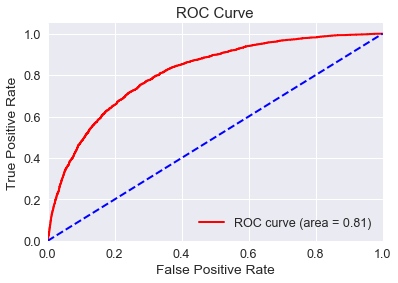

In [72]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [73]:
result5.params

Intercept                 -3.026594
car_type[T.Panel Truck]    0.487362
car_type[T.Pickup]         0.512193
car_type[T.Sports Car]     1.004393
car_type[T.Van]            0.579090
car_type[T.z_SUV]          0.735654
bluebook                  -0.000025
kidsdriv                   0.385152
homekids                   0.040194
mvr_pts                    0.101270
tif                       -0.055153
travtime                   0.015256
IMP_sex                   -0.051815
IMP_age                   -0.001608
IMP_car_age                0.003245
IMP_home_val              -0.000001
IMP_income                -0.000002
IMP_urbanicity             2.294315
IMP_revoked                1.018313
IMP_mstatus               -0.493337
IMP_car_use                0.701914
IMP_parent1                0.378644
home_own                  -0.275896
university_degree         -0.473891
white_collar              -0.505765
hadFewOldClaim             0.542106
hadManyOldClaim           -0.134471
dtype: float64

In [74]:
df_new_3 = df_new_VIF.copy()
del(df_new_3["IMP_sex"])
del(df_new_3["IMP_age"])
del(df_new_3["IMP_car_age"])
del(df_new_3["IMP_income"])
del(df_new_3["homekids"])
del(df_new_3["hadManyOldClaim"])

In [75]:
tempList = list(df_new_3.columns.values)
tempList.remove("target_flag")
testFeatures = "+".join(tempList)

In [76]:
logit6 = smf.logit('target_flag ~ ' + testFeatures, data=df_new_3)
result6 = logit6.fit()
print(result6.summary())
print(result6.summary2())

Optimization terminated successfully.
         Current function value: 0.448770
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            target_flag   No. Observations:                 8161
Model:                          Logit   Df Residuals:                     8140
Method:                           MLE   Df Model:                           20
Date:                Sat, 17 Feb 2018   Pseudo R-squ.:                  0.2222
Time:                        15:01:17   Log-Likelihood:                -3662.4
converged:                       True   LL-Null:                       -4709.0
                                        LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.0294      0.188    -16.111      0.000      -3.398   

In [77]:
preds = result6.predict()
fpr, tpr, _ = metrics.roc_curve(df_new['target_flag'], preds)
 
# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.8121282631054554


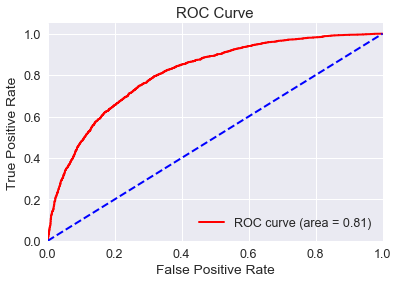

In [78]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [79]:
result6.params

Intercept                 -3.029387
car_type[T.Panel Truck]    0.509909
car_type[T.Pickup]         0.511055
car_type[T.Sports Car]     0.960046
car_type[T.Van]            0.588792
car_type[T.z_SUV]          0.700949
bluebook                  -0.000028
kidsdriv                   0.411535
mvr_pts                    0.098217
tif                       -0.054662
travtime                   0.015223
IMP_home_val              -0.000002
IMP_urbanicity             2.279233
IMP_revoked                0.974251
IMP_mstatus               -0.448729
IMP_car_use                0.694495
IMP_parent1                0.465875
home_own                  -0.285503
university_degree         -0.499085
white_collar              -0.524400
hadFewOldClaim             0.562707
dtype: float64

In [80]:
df_new_3["log_bluebook"] = np.log(df_new_3.bluebook)
df_new_3["log_IMP_home_val"] = np.log(df_new_3.IMP_home_val)

In [81]:
tempList = list(df_new_3.columns.values)
tempList.remove("target_flag")
tempList.remove("bluebook")
tempList.remove("IMP_home_val")

In [82]:
testFeatures = "+".join(tempList)
logit7 = smf.logit('target_flag ~ ' + testFeatures, data=df_new_3)
result7 = logit7.fit()
print(result7.summary())
print(result7.summary2())

Optimization terminated successfully.
         Current function value: 0.448241
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            target_flag   No. Observations:                 8161
Model:                          Logit   Df Residuals:                     8140
Method:                           MLE   Df Model:                           20
Date:                Sat, 17 Feb 2018   Pseudo R-squ.:                  0.2232
Time:                        15:01:17   Log-Likelihood:                -3658.1
converged:                       True   LL-Null:                       -4709.0
                                        LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.9605      1.235      4.016      0.000       2.540   

In [83]:
preds = result7.predict()
fpr, tpr, _ = metrics.roc_curve(df_new_3['target_flag'], preds)
 
# calculate AUC and create ROC curve
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.8128119775892555


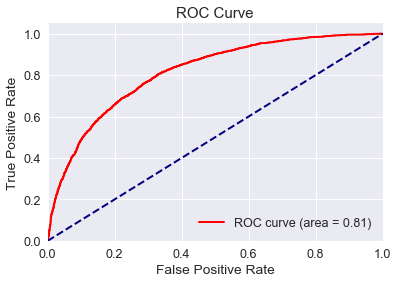

In [84]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [85]:
pred_train = preds
pred_out = df_new_3.loc[:,['index','target_flag']]
pred_out['p_target_flag'] = pred_train[: ]
pred_out.head 
#sort by pred
result_1 = pred_out.sort_values(by=('p_target_flag'))
print(result_1)

      index  target_flag  p_target_flag
2591    NaN            0       0.002281
7305    NaN            0       0.002489
2139    NaN            0       0.002504
4930    NaN            0       0.002701
713     NaN            0       0.002722
3231    NaN            0       0.003020
2917    NaN            0       0.003021
568     NaN            0       0.003167
4070    NaN            0       0.003208
997     NaN            0       0.003332
5056    NaN            0       0.003421
6193    NaN            0       0.003682
2439    NaN            0       0.003712
5014    NaN            0       0.003950
2716    NaN            0       0.004337
6494    NaN            0       0.004401
2227    NaN            0       0.004499
6257    NaN            0       0.004537
4324    NaN            0       0.004753
6585    NaN            0       0.004788
7894    NaN            0       0.005069
2133    NaN            0       0.005280
11      NaN            0       0.005411
539     NaN            0       0.005414


//anaconda/envs/PREDICT/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
//anaconda/envs/PREDICT/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [86]:
result_2 = pd.qcut(result_1['p_target_flag'], 10, labels=[1,2,3,4,5,6,7,8,9,10])
print (result_2)
d1 = {'g' : result_2}
df3 = pd.DataFrame(data=d1)
print (df3)
result_3 = pd.concat([result_1, df3], axis=1, join_axes=[result_1.index])
print (result_3)

2591     1
7305     1
2139     1
4930     1
713      1
3231     1
2917     1
568      1
4070     1
997      1
5056     1
6193     1
2439     1
5014     1
2716     1
6494     1
2227     1
6257     1
4324     1
6585     1
7894     1
2133     1
11       1
539      1
74       1
871      1
6200     1
115      1
6413     1
3035     1
        ..
7051    10
5039    10
468     10
6676    10
6789    10
8091    10
8130    10
7670    10
5586    10
905     10
1710    10
1878    10
7528    10
6260    10
2441    10
5827    10
1934    10
788     10
2182    10
2198    10
5905    10
3752    10
5443    10
2481    10
5863    10
1758    10
4777    10
5651    10
5122    10
3409    10
Name: p_target_flag, Length: 8161, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]
       g
2591   1
7305   1
2139   1
4930   1
713    1
3231   1
2917   1
568    1
4070   1
997    1
5056   1
6193   1
2439   1
5014   1
2716   1
6494   1
2227   1
6257   1
4324   1
6585   1
7894   1
2133   1
11     1
539

In [87]:
sums = result_3.groupby('g')
sums1 = sums.aggregate(np.sum)
print (sums1)


    index  target_flag  p_target_flag
g                                    
1     0.0           16      16.871514
2     0.0           39      38.155152
3     0.0           63      63.703297
4     0.0          104      95.892798
5     0.0          125     140.336273
6     0.0          202     192.865994
7     0.0          245     256.302527
8     0.0          318     332.356158
9     0.0          450     429.675272
10    0.0          591     586.841015


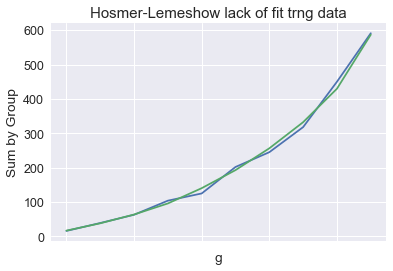

In [88]:
#plot target_flag vs pred
def scat(dataframe,var1,var2,var3):     
    dataframe[var2].plot()     
    dataframe[var3].plot()     
    plt.title('Hosmer-Lemeshow lack of fit trng data')     
    plt.xlabel(var1)     
    plt.ylabel('Sum by Group')
    
scat(sums1, 'g', 'target_flag', 'p_target_flag')

In [89]:
df2 = df[df.target_flag == 1]

#continuous vars correlation
df2[continuous_vars].corrwith(df2.target_amt)

#categorical vars correlation
df2[dummy_columns].corrwith(df2.target_amt)

df2["log_bluebook"] = np.log(df2.bluebook)

features2 = "log_bluebook+IMP_mstatus+mvr_pts"
result2 = smf.ols('target_amt ~' + features2, data=df2).fit()
print(result2.summary())

y = df2.target_amt

#Get predictions and residuals
x2_predictions = result2.predict()
x2_residuals = y - x2_predictions

                            OLS Regression Results                            
Dep. Variable:             target_amt   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.07
Date:                Sat, 17 Feb 2018   Prob (F-statistic):           4.41e-09
Time:                        15:01:18   Log-Likelihood:                -20940.
No. Observations:                2153   AIC:                         4.189e+04
Df Residuals:                    2149   BIC:                         4.191e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2113.3893   1258.219     -1.680   

//anaconda/envs/PREDICT/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


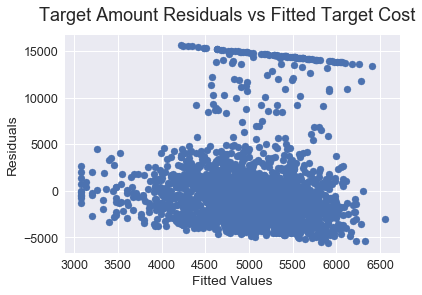

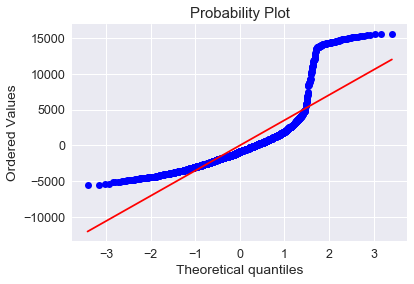

2641.252764155822


In [90]:
fig = plt.figure()
plt.scatter(x=x2_predictions, y= x2_residuals)
fig.suptitle('Target Amount Residuals vs Fitted Target Cost')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

#QQPlot
stats.probplot(x2_residuals, dist="norm", plot=plt)
plt.show()

print(metrics.mean_absolute_error(y, x2_predictions))

In [91]:
test1 = test.copy()
test_columns = list(test1.columns.values)

In [92]:
test1.job = test1.job.fillna("Missing Job Info")
test_na_columns = test1.isnull().any()

In [93]:
for index in test_columns:
    if test1[index].astype(str).str.contains("\$").any() == True:
        tempVals = []
        for money in test1[index].values:
            if not pd.isnull(money):
                value = int(Decimal(sub(r'[^\d\-.]', '', money)))
                tempVals.append(value)
            else:
                tempVals.append(np.nan)
        test1[index] = tempVals

In [94]:
test1["home_own"] = np.where(test1["home_val"].fillna(0) > 0, 1, 0)

In [95]:
test1=test1.fillna(0)

In [96]:
for index in test_columns:
    if test_na_columns[index] == True:
        new_name = "IMP_" + index
        new_index = "m_" + index
        m = np.median(train1[index][train1[index] > 0])
        test1[new_name] = test1[index].replace({0: m}).astype(int)
        test1[new_index] = (test1[index] == 0).astype(int)

In [97]:
test1.loc[test1.education == "<High School", 'education'] = "z_High School"
test1.education.value_counts()

z_High School    934
Bachelors        581
Masters          420
PhD              206
Name: education, dtype: int64

In [98]:
test1.IMP_income = replace_outliers_with_q1_q2(test1.IMP_income)
test1.IMP_home_val = replace_outliers_with_q1_q2(test1.IMP_home_val)
test1.bluebook = replace_outliers_with_q1_q2(test1.bluebook)
test1.travtime = replace_outliers_with_q1_q2(test1.travtime)

In [99]:
test1["white_collar"] = np.where(test1["job"].isin(["Doctor", "Manager", 
       "Lawyer"]), 1, 0)
test1["university_degree"] = np.where(test1["education"].isin(["Bachelors",
       "Masters", "PhD"]), 1, 0)

In [100]:
test1["hadOldClaim"] = np.where(test1["oldclaim"] > 0, 1, 0)
test1["hadFewOldClaim"] = np.where((test1["oldclaim"] > 0) & (test1["oldclaim"] <= 12000), 1, 0)
test1["hadManyOldClaim"] = np.where(test1["oldclaim"] > 12000, 1, 0)

test1["IMP_mstatus"] = np.where(test1["mstatus"].isin(["Yes"]), 1, 0)
test1["IMP_parent1"] = np.where(test1["parent1"].isin(["Yes"]), 1, 0)
test1["IMP_sex"] = np.where(test1["sex"].isin(["z_F"]), 1, 0)
test1["IMP_revoked"] = np.where(test1["revoked"].isin(["Yes"]), 1, 0)
test1["IMP_red_car"] = np.where(test1["red_car"].isin(["yes"]), 1, 0)
test1["IMP_urbanicity"] = np.where(test1["urbanicity"].isin(["Highly Urban/ Urban"]), 1, 0)
test1["IMP_car_use"] = np.where(test1["car_use"].isin(["Commercial"]), 1, 0)

test1["log_bluebook"] = np.log(test1.bluebook)
test1["log_IMP_home_val"] = np.log(test1.IMP_home_val)


In [101]:
preds = result7.predict(test1)
print(preds.head)
pred_out = test1.loc[:,['index','target_flag']]
pred_out['p_target_flag'] = preds[: ]
print(pred_out.head)

<bound method NDFrame.head of 0       0.154922
1       0.347799
2       0.137867
3       0.260701
4       0.237174
5       0.228183
6       0.388939
7       0.331023
8       0.033437
9       0.164020
10      0.026531
11      0.550464
12      0.852222
13      0.076881
14      0.034385
15      0.606916
16      0.775465
17      0.169523
18      0.622052
19      0.444605
20      0.116418
21      0.380103
22      0.061666
23      0.344472
24      0.288498
25      0.402752
26      0.522537
27      0.514844
28      0.085499
29      0.151714
          ...   
2111    0.079820
2112    0.420814
2113    0.029187
2114    0.114057
2115    0.037079
2116    0.410882
2117    0.316479
2118    0.900720
2119    0.164821
2120    0.054942
2121    0.253744
2122    0.720268
2123    0.315233
2124    0.253545
2125    0.039718
2126    0.429300
2127    0.128391
2128    0.064832
2129    0.040632
2130    0.149847
2131    0.217652
2132    0.173098
2133    0.293550
2134    0.479469
2135    0.025785
2136    0.373035
2

In [102]:
preds2 = result2.predict(test1)
pred_out['p_target_amt'] = preds2[: ]
pred_out.head


<bound method NDFrame.head of       index  target_flag  p_target_flag  p_target_amt
0         3          0.0       0.154922   5655.647852
1         9          0.0       0.347799   5541.819111
2        10          0.0       0.137867   4522.897565
3        18          0.0       0.260701   4864.931747
4        21          0.0       0.237174   5512.963694
5        30          0.0       0.228183   5371.899084
6        31          0.0       0.388939   4616.496320
7        37          0.0       0.331023   5512.619468
8        39          0.0       0.033437   5690.966655
9        47          0.0       0.164020   6056.719342
10       60          0.0       0.026531   5303.063068
11       62          0.0       0.550464   5336.999437
12       63          0.0       0.852222   4875.621583
13       64          0.0       0.076881   4703.364400
14       68          0.0       0.034385   4817.700830
15       75          0.0       0.606916   5161.035681
16       76          0.0       0.775465   3585.33720

In [103]:
pred_out.columns

Index(['index', 'target_flag', 'p_target_flag', 'p_target_amt'], dtype='object')

In [104]:
your_model = pred_out.loc[:,['index','p_target_flag','p_target_amt']]  
print(your_model.head())
your_model.to_csv('Insurance_Logistic_Regression_predictions.csv', index=False)

   index  p_target_flag  p_target_amt
0      3       0.154922   5655.647852
1      9       0.347799   5541.819111
2     10       0.137867   4522.897565
3     18       0.260701   4864.931747
4     21       0.237174   5512.963694


In [105]:
d = {'p_target': pred_out.loc[:,'p_target_flag'] * pred_out.loc[:,'p_target_amt']}
kaggle_df_2 =pd.DataFrame(data=d)
print(kaggle_df_2.head())
kaggle_df_1 = pred_out.loc[:,'index']
print(kaggle_df_1.head())
kaggle_model = pd.concat([kaggle_df_1,kaggle_df_2],axis = 1, join_axes=[kaggle_df_1.index])
print(kaggle_model.head())
kaggle_model.to_csv('Insurance_Logistic_Regression_kaggle_predictions.csv', index=False)

      p_target
0   876.182342
1  1927.438829
2   623.557866
3  1268.292310
4  1307.532922
0     3
1     9
2    10
3    18
4    21
Name: index, dtype: int64
   index     p_target
0      3   876.182342
1      9  1927.438829
2     10   623.557866
3     18  1268.292310
4     21  1307.532922
